# Example Usage & Plotting

In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
from sklearn.manifold import SpectralEmbedding
import networkx
import pandas as pd
import random
import networkx

# load libraries
import os
from geneclusters.cluster_genes_new import get_gene_pathway_matrix, create_random_labeling, run_KL, evaluate_cut
import numpy as np
from os import path
from tqdm.contrib.concurrent import process_map
from functools import partial

# Functions

from geneclusters.cluster_genes_new import evaluate_cut, plot_component, plot_edges, plot_nodes, plot_single_cluster, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

In [2]:
# load matrix
mat = pd.read_csv('../../../TsaiMadry_shared/clusters/GO_Biological_Process_2023_subset_mat.csv', index_col=0)

In [3]:
def loop_once(matrix, threshold, C=0, KL_modified=True, no_progress=False, seed=None):
    labeling = create_random_labeling(matrix, threshold, seed)
    run_KL(labeling, matrix, C, KL_modified, no_progress, seed)
    loss = evaluate_cut(matrix, labeling, C)                           
    return labeling, loss


In [ ]:
# do KL
matrix = np.ascontiguousarray(mat.values.T)

threshold = 30
C = 0
KL_modified = True
no_progress = False 

lab, los = loop_once(matrix, threshold, C, KL_modified, no_progress, 1)

0it [00:00, ?it/s]

In [89]:
evaluate_cut(matrix, lab, 0)

74022

In [90]:
np.save('../../../TsaiMadry_shared/clusters/Labels_KL.npy', lab)

In [77]:
# do spectral 
from sklearn.cluster import SpectralClustering
# compare to spectral clustering
N = sum(matrix.shape)
full_matrix = np.zeros((N,N))
full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
full_matrix[matrix.shape[0]:,:matrix.shape[0]] = matrix.T
clustering = SpectralClustering(n_clusters=500,
       assign_labels='discretize',
       random_state=0, affinity='precomputed').fit(full_matrix.T)
L = clustering.labels_

evaluate_cut(matrix, L, 0)

In [87]:
np.save('../../../TsaiMadry_shared/clusters/Labels_spectral.npy', L)

In [82]:
N/500

16.418

In [ ]:

repeats = 100
thresh = np.repeat(T,repeats)
seed = np.arange(repeats)
C = 0
KL_modified = True
random_labels = True
unweighted = True
no_progress = True

get_scores(path,C,KL_modified,random_labels,unweighted, no_progress, mat), seed, thresh)

loss = np.hstack([x[1] for x in results])
labs = np.vstack([x[0] for x in results])
labels = labs[np.argmin(loss)]

In [30]:
p = './examples/.npy'
mat = get_gene_pathway_matrix(p)

In [31]:
np.sum(mat.shape)

20103

In [32]:
genes = set(pd.read_csv('../ABCA7lof/processed_data/single_cell_data/exp.csv')['gene'])

In [33]:
index = [x in genes for x in np.array(mat.columns)]
m = np.array(mat.loc[:,index])
m = m[np.sum(m, axis=1)>5]
m = m[:,(np.sum(m, axis=0)>0)]

In [65]:
np.sum(m.shape)

13398

In [44]:
np.sum(np.sum(m, axis=1)>5)

2578

In [41]:
mat.shape

(5406, 14697)

## Choose initiation

In [3]:
p = './examples/GO_Biological_Process_2023.npy'
mat = get_gene_pathway_matrix(p)
N = 1000

mmap_1 = './examples/GO_Biological_Process_2023_labels_30.npy'
mmap_2 = './examples/GO_Biological_Process_2023_losses_30.npy'

mode = 'r'

labels = np.lib.format.open_memmap(mmap_1, shape=(N, sum(mat.shape)), dtype=int, mode=mode)
losses = np.lib.format.open_memmap(mmap_2, shape=(1, N), dtype=int, mode=mode)
index = losses[0]!=0

losses_sub = losses[0][index]
labels_sub = labels[index]


In [97]:
labels_sele = labels_sub[np.argsort(losses_sub)[0]]

In [100]:
len(np.unique(labels_sele))

671

In [ ]:
from sklearn.cluster import SpectralClustering
import numpy as np
X = mat
clustering = SpectralClustering(n_clusters=671,
       assign_labels='discretize',
       random_state=0, affinity='precomputed').fit(full_matrix)

In [102]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [116]:
N = sum(X.shape)
full_matrix = np.zeros((N,N))

full_matrix[:X.shape[0],X.shape[0]:] = X
full_matrix[X.shape[0]:,:X.shape[0]] = X.T

In [112]:
comps = connected_components(full_matrix)

In [113]:
comps

(1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

In [49]:
@nb.njit(parallel=True)
def compute_jaccard(out, labels_25, labels_50, N):
    for i in nb.prange(N):
        x = set(np.where(labels_25==labels_25[i])[0])
        y = set(np.where(labels_50==labels_50[i])[0])
        out[i] = len(x.intersection(y))/len(x.union(y))

In [50]:
labels_sele = labels_sub[np.argsort(losses_sub)[:5]]

In [51]:
i = labels_sele.shape[0]
N = labels_sele.shape[1]

out = np.empty((i,i))
temp = np.empty(N)
for index in range(i):
    for index2 in range(i):
        compute_jaccard(temp, labels_sele[index], labels_sele[index2], N)
        out[index,index2] = np.mean(temp)

In [52]:
out

array([[1.        , 0.16813441, 0.16950572, 0.16512805, 0.16962319],
       [0.16813441, 1.        , 0.16155245, 0.16935977, 0.16911124],
       [0.16950572, 0.16155245, 1.        , 0.1690845 , 0.16383319],
       [0.16512805, 0.16935977, 0.1690845 , 1.        , 0.16632002],
       [0.16962319, 0.16911124, 0.16383319, 0.16632002, 1.        ]])

In [73]:
labeling = labels_sele[2]
matrix = np.ascontiguousarray(mat.values.T)
pathway_names = mat.index
gene_names = mat.columns
frame = pd.DataFrame(labeling)
frame['description'] = np.concatenate([gene_names, pathway_names])
frame['is_gene'] = np.arange(frame.shape[0]) < matrix.shape[0]

In [74]:
frame.columns = ['cluster', 'description', 'is_gene']

In [75]:
frame.head()

,cluster,description,is_gene
0,362,A4GNT,True
1,295,AAK1,True
2,309,AARS1,True
3,154,AARS2,True
4,377,AASDHPPT,True


# Cluster merging

In [76]:
matrix = np.array(mat)
cols = np.array(frame[frame['is_gene']]['cluster'])
rows = np.array(frame[np.invert(frame['is_gene'])]['cluster'])

In [77]:
# merge clusters that fall within certain threshold
groupped_matrix, mapping = compute_groupped_matrix(matrix, cols, rows)
to_merge = find_similar_clusters(groupped_matrix)
inverse_mapping = {v: k for (k, v) in mapping.items()}
to_merge_remapped = {inverse_mapping[k]: inverse_mapping[v] for (k, v) in to_merge.items()}
update_mapping = np.vectorize(lambda x: to_merge_remapped.get(x, x))
new_cols = update_mapping(cols)
new_rows = update_mapping(rows)
groupped_matrix_new, mapping = compute_groupped_matrix(matrix, new_cols, new_rows)

In [78]:
frame['new_cluster'] = np.concatenate((new_cols, new_rows))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


671
668


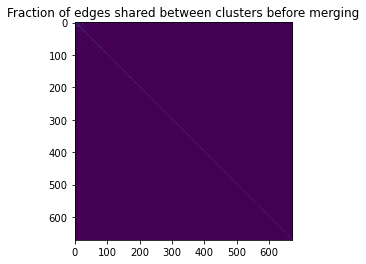

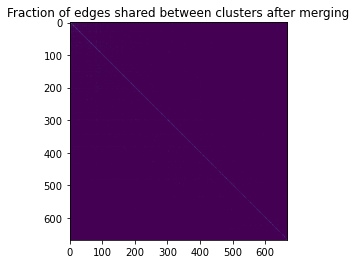

In [79]:
# plot pre and post merge heatmaps
# inspect the pre-merge heatmap to see if any clusters need to be merged
# specify the threshold accordingly 

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
X_transformed_new = embedding.fit_transform(groupped_matrix_new)
X_transformed = embedding.fit_transform(groupped_matrix)

o = np.argsort(X_transformed.ravel())
plt.imshow((groupped_matrix[o][:,o]))
plt.title('Fraction of edges shared between clusters before merging')

plt.figure()
o = np.argsort(X_transformed_new.ravel())
plt.imshow((groupped_matrix_new[o][:,o]))
plt.title('Fraction of edges shared between clusters after merging')

print(X_transformed.shape[0])
print(X_transformed_new.shape[0])

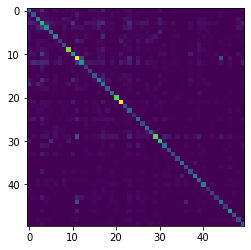

In [80]:
plt.imshow((groupped_matrix_new[o][:,o][:50,:50]))


In [25]:
frame.to_csv('./examples/GO_Biological_Process_2023_25_frame.csv')

# Assign represenative names

In [81]:
mat = get_gene_pathway_matrix(p)
colnames = np.array(mat.columns)
rownames = np.array(mat.index)

out = [get_representative_name_per_cluster(np.array(mat), colnames, rownames, frame, x) for x in np.unique(frame['new_cluster'])]
names = pd.DataFrame(out)
names.columns = ['cluster_ID', 'representative_pathway', 'fraction_internal_connections', 'N_internal_connections']


In [82]:
names.to_csv('./examples/GO_Biological_Process_2023_30_names_2.csv')

In [94]:
df1 = pd.read_csv('./examples/GO_Biological_Process_2023_30_names_2.csv')
np.sum(np.isnan(np.array(df1['fraction_internal_connections'])))

11

In [93]:
df2 = pd.read_csv('./examples/GO_Biological_Process_2023_30_names_1.csv')
np.sum(np.isnan(np.array(df2['fraction_internal_connections'])))

10

In [92]:
df3 = pd.read_csv('./examples/GO_Biological_Process_2023_30_names_0.csv')
np.sum(np.isnan(np.array(df3['fraction_internal_connections'])))

11

In [38]:
names.head()

,cluster_ID,representative_pathway,fraction_internal_connections,N_internal_connections
0,C.0,NaN,NaN,NaN
1,C.1,L-phenylalanine Catabolic Process,1.000000,5.0
2,C.2,Positive Regulation Of Monocyte Chemotaxis,0.611111,11.0
3,C.3,Response To Lead Ion,0.500000,3.0
4,C.4,Positive Regulation Of Coagulation,0.545455,6.0
